In [1]:
import pandas as pd
import numpy as np
import requests
import re
import json
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point,Polygon,shape
from shapely.ops import split
import glob

In [2]:
all_files=glob.glob(r'C:\Users\飘哥\Desktop\通勤数据\分析数据\*.csv')
all_files=all_files[0:1]
all_files

['C:\\Users\\飘哥\\Desktop\\通勤数据\\分析数据\\6月5日OD.csv']

In [3]:
all_dataframe=[]
for i in all_files:
    result=pd.read_csv(i)
    all_dataframe.append(result)
final=pd.concat(all_dataframe,0)
final=final.reset_index(drop=True)
final

,hour,FSTR_ONAME,FSTR_DNAME,实际值,常态值,变化量,dist,time,Ocat,Oloc,Dcat,Dloc,rainvalue
0,6,七宝,上海南站,2,4.00,-2.00,15.373,43.133333,混合区,郊区,混合区,中外环,10.51
1,7,七宝,上海南站,12,9.75,2.25,15.373,43.133333,混合区,郊区,混合区,中外环,7.79
2,8,七宝,上海南站,15,12.25,2.75,15.373,43.133333,混合区,郊区,混合区,中外环,0.14
3,9,七宝,上海南站,8,3.00,5.00,15.373,43.133333,混合区,郊区,混合区,中外环,0.18
4,10,七宝,上海南站,1,5.92,-4.92,15.373,43.133333,混合区,郊区,混合区,中外环,2.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545510,20,真如,上南路,1,1.00,0.00,17.234,39.916667,混合区,中外环,居住区,中外环,0.00
545511,20,紫藤路,杨高北路,1,1.00,0.00,30.433,71.200000,混合区,中外环,居住区,中外环,0.00
545512,20,龙阳路,东川路,1,1.00,0.00,38.862,78.933333,混合区,中外环,混合区,郊区,0.00
545513,21,新闸路,李子园,1,1.00,0.00,11.345,35.200000,工作区,内环,混合区,中外环,0.00


## 停靠点数据 

In [5]:
#读取OD停靠点数据,没有重复
df=gpd.read_feather(r'C:\Users\飘哥\Desktop\OD图形爬取\OD停靠点.feather')
df

,FSTR_ONAME,FSTR_DNAME,station_a,station_b,geometry
0,七宝,漕宝路,七宝,星中路,"LINESTRING (121.34576 31.15742, 121.36360 31.1..."
1,七宝,漕宝路,星中路,合川路,"LINESTRING (121.36510 31.16044, 121.37934 31.1..."
2,七宝,漕宝路,合川路,漕河泾开发区,"LINESTRING (121.38081 31.16860, 121.39239 31.1..."
3,七宝,漕宝路,漕河泾开发区,桂林路,"LINESTRING (121.39394 31.17252, 121.41310 31.1..."
4,七宝,漕宝路,桂林路,宜山路,"LINESTRING (121.41437 31.17739, 121.42210 31.1..."
...,...,...,...,...,...
760764,龙阳路,金运路,大渡河路,真北路,"LINESTRING (121.38923 31.23363, 121.37806 31.2..."
760765,龙阳路,金运路,真北路,祁连山南路,"LINESTRING (121.37651 31.23440, 121.36346 31.2..."
760766,龙阳路,金运路,祁连山南路,丰庄,"LINESTRING (121.36197 31.23968, 121.35143 31.2..."
760767,龙阳路,金运路,丰庄,金沙江西路,"LINESTRING (121.34990 31.24430, 121.33083 31.2..."


## 变化量数据 

In [52]:
#读取属性数据
data=final.query('hour==19').reset_index(drop=True)
data=data[['FSTR_ONAME','FSTR_DNAME','变化量']]
#同一OD名合并,这里将四天OD求平均了
# data2=data.groupby(['FSTR_ONAME','FSTR_DNAME']).sum().reset_index()
data2=data.groupby(['FSTR_ONAME','FSTR_DNAME']).mean().reset_index()
data2

,FSTR_ONAME,FSTR_DNAME,变化量
0,七宝,三林,-0.50
1,七宝,三林东,1.75
2,七宝,上南路,0.00
3,七宝,上大路,0.00
4,七宝,上海儿童医学中心,0.00
...,...,...,...
34168,龙阳路,鹤沙航城,5.25
34169,龙阳路,黄兴路,0.00
34170,龙阳路,黄陂南路,0.00
34171,龙阳路,龙柏新村,-0.50


In [53]:
#属性匹配
data3=pd.merge(df,data2,on=['FSTR_ONAME','FSTR_DNAME'],how='left')
data3=data3.dropna().reset_index(drop=True)
data3

,FSTR_ONAME,FSTR_DNAME,station_a,station_b,geometry,变化量
0,七宝,漕宝路,七宝,星中路,"LINESTRING (121.34576 31.15742, 121.36360 31.1...",0.0
1,七宝,漕宝路,星中路,合川路,"LINESTRING (121.36510 31.16044, 121.37934 31.1...",0.0
2,七宝,漕宝路,合川路,漕河泾开发区,"LINESTRING (121.38081 31.16860, 121.39239 31.1...",0.0
3,七宝,漕宝路,漕河泾开发区,桂林路,"LINESTRING (121.39394 31.17252, 121.41310 31.1...",0.0
4,七宝,漕宝路,桂林路,宜山路,"LINESTRING (121.41437 31.17739, 121.42210 31.1...",0.0
...,...,...,...,...,...,...
378602,龙阳路,金运路,大渡河路,真北路,"LINESTRING (121.38923 31.23363, 121.37806 31.2...",2.0
378603,龙阳路,金运路,真北路,祁连山南路,"LINESTRING (121.37651 31.23440, 121.36346 31.2...",2.0
378604,龙阳路,金运路,祁连山南路,丰庄,"LINESTRING (121.36197 31.23968, 121.35143 31.2...",2.0
378605,龙阳路,金运路,丰庄,金沙江西路,"LINESTRING (121.34990 31.24430, 121.33083 31.2...",2.0


## 合并为OD线段变化量

In [54]:
#得到每一条线段的变化量
splited_lines=data3.groupby(['station_a','station_b']).sum().reset_index()
splited_lines.columns=['station_a','station_b','FLOW']
splited_lines

,station_a,station_b,FLOW
0,七宝,中春路,176.54
1,七宝,星中路,-80.18
2,七莘路,虹莘路,19.17
3,三林,三林东,63.33
4,三林,东方体育中心,-43.06
...,...,...,...
819,龙阳路,世纪公园,-51.25
820,龙阳路,华夏中路,108.35
821,龙阳路,张江高科,-8.82
822,龙阳路,花木路,9.90


## 读取OD线段底图 

In [55]:
#线段geometry属性
od_geo=gpd.read_file(r'C:\Users\飘哥\Desktop\OD图形爬取\od线段底图.shp',encoding='utf-8')
od_geo

,station_a,station_b,geometry
0,七宝,星中路,"LINESTRING (121.34576 31.15742, 121.36360 31.1..."
1,星中路,合川路,"LINESTRING (121.36510 31.16044, 121.37934 31.1..."
2,合川路,漕河泾开发区,"LINESTRING (121.38081 31.16860, 121.39239 31.1..."
3,漕河泾开发区,桂林路,"LINESTRING (121.39394 31.17252, 121.41310 31.1..."
4,桂林路,宜山路,"LINESTRING (121.41437 31.17739, 121.42210 31.1..."
...,...,...,...
836,汉中路,中潭路,"LINESTRING (121.45353 31.24353, 121.43708 31.2..."
837,枫桥路,隆德路,"LINESTRING (121.40709 31.24326, 121.41834 31.2..."
838,淞虹路,虹桥1号航站楼,"LINESTRING (121.35451 31.21927, 121.34297 31.1..."
839,石龙路,桂林公园,"LINESTRING (121.43776 31.16010, 121.41539 31.1..."


In [56]:
#匹配geometry属性
splited_lines=pd.merge(splited_lines,od_geo,on=['station_a','station_b'],how='left').dropna()
splited_lines

,station_a,station_b,FLOW,geometry
0,七宝,中春路,176.54,"LINESTRING (121.34426 31.15695, 121.33379 31.1..."
1,七宝,星中路,-80.18,"LINESTRING (121.34576 31.15742, 121.36360 31.1..."
2,七莘路,虹莘路,19.17,"LINESTRING (121.35929 31.13402, 121.37478 31.1..."
3,三林,三林东,63.33,"LINESTRING (121.50799 31.14536, 121.51803 31.1..."
4,三林,东方体育中心,-43.06,"LINESTRING (121.50647 31.14538, 121.47686 31.1..."
...,...,...,...,...
828,龙阳路,世纪公园,-51.25,"LINESTRING (121.55271 31.20555, 121.54725 31.2..."
829,龙阳路,华夏中路,108.35,"LINESTRING (121.55381 31.20439, 121.57760 31.1..."
830,龙阳路,张江高科,-8.82,"LINESTRING (121.55407 31.20496, 121.58275 31.2..."
831,龙阳路,花木路,9.90,"LINESTRING (121.55368 31.20568, 121.55771 31.2..."


In [57]:
#生成段
step = 10
splited_lines['FLOW1']=abs(splited_lines['FLOW'])
splited_lines = splited_lines.sort_values(by = 'FLOW1')
splited_lines['linewidth'] = (np.array(range(len(splited_lines)))*step/len(splited_lines)).astype('int')/step+0.1
splited_lines=splited_lines.reset_index(drop=True)
splited_lines

,station_a,station_b,FLOW,geometry,FLOW1,linewidth
0,高桥西,双江路,0.00,"LINESTRING (121.54444 31.35378, 121.53603 31.3...",0.00,0.1
1,锦秋路,丰翔路,0.00,"LINESTRING (121.37713 31.32149, 121.37639 31.3...",0.00,0.1
2,徐泾东,诸光路,0.00,"LINESTRING (121.29419 31.19067, 121.28938 31.1...",0.00,0.1
3,中山北路,中潭路,0.00,"LINESTRING (121.45386 31.26047, 121.43723 31.2...",0.00,0.1
4,顾村公园,锦秋路,0.00,"LINESTRING (121.36866 31.34566, 121.37691 31.3...",0.00,0.1
...,...,...,...,...,...,...
828,星中路,七宝,323.03,"LINESTRING (121.36360 31.15995, 121.34576 31.1...",323.03,1.0
829,合川路,星中路,328.96,"LINESTRING (121.37934 31.16800, 121.36510 31.1...",328.96,1.0
830,漕河泾开发区,桂林路,353.43,"LINESTRING (121.39394 31.17252, 121.41310 31.1...",353.43,1.0
831,宜山路,徐家汇,477.71,"LINESTRING (121.42317 31.18872, 121.43082 31.1...",477.71,1.0


In [58]:
#新建一个变量，splited_duans来存储生成的面
splited_duans = splited_lines.copy()
#设定一下我们想要的面宽度
kuandu = 0.005
#将每一段变成面后赋值给OD的geome属性
geo=[]
for i in range(len(splited_lines)):
    r = splited_lines.iloc[i]
    ply = Polygon(np.append(np.array(r['geometry'].coords),
    np.array(r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3).coords)).reshape(-1,2))#调整线段宽度
    geo.append(ply)
splited_duans['geometry']=geo

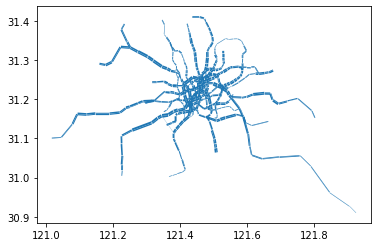

In [59]:
#定义坐标系
splited_duans2=splited_duans.set_crs("EPSG:4326")
splited_duans2.plot()

## 文件保存及出图 

In [60]:
splited_duans2.to_file(r'C:\Users\飘哥\Desktop\通勤数据\图层\6月5日\19点.shp',encoding='utf-8')

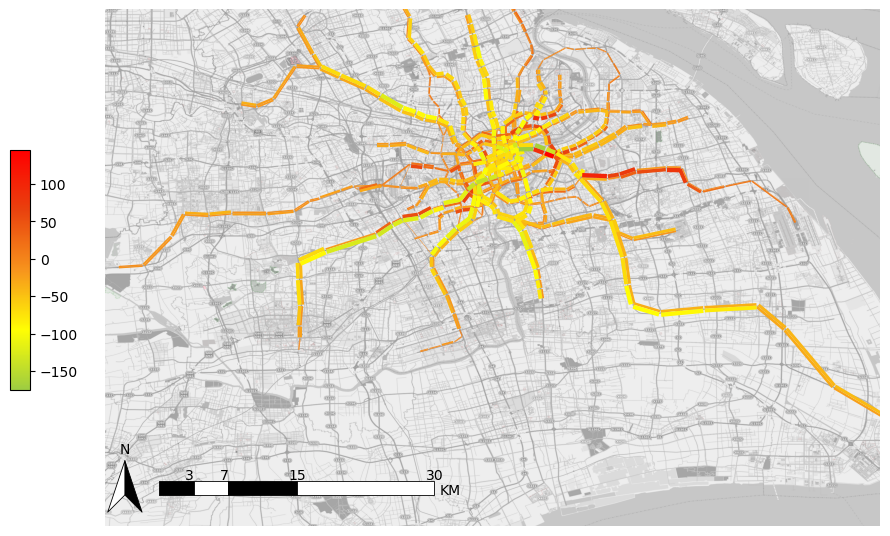

In [286]:
splited_duans1 = splited_duans.copy()
#设定显示范围
# lat1sh = 30.8666667;
# lat2sh = 31.5833333;
# lon1sh = 121.066667;
# lon2sh = 122.0;
# bounds = [lon1sh+0.2,lat1sh+0.2,lon2sh-0.2,lat2sh-0.3]
bounds = [121,30.8,121.9,31.4]
import plot_map
#导入必要的包
import pandas as pd
import numpy as np
#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt
#geopandas包
import geopandas

#定义画的大小
fig     = plt.figure(1,(10,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)

#plot_map包绘制背景图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#设定colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)
vmax = splited_duans['FLOW'].max()
vmin = splited_duans['FLOW'].min()

#把前面搞出来的画上去
splited_duans1.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = vmin,vmax = vmax)
# splited_duans2.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)

# 加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 3800,rect = [0.07,0.06])

#设定显示范围,坐标轴
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#绘制colorbar
plt.imshow([[vmin,vmax]], cmap=cmap)
cax = plt.axes([0.03, 0.35, 0.02, 0.3])
plt.colorbar(cax=cax)
plt.savefig(r'C:\Users\飘哥\Desktop\7点.png',dpi=800,bbox_inches='tight')
plt.show()

## 示例 

In [54]:
splited_lines=df.query('FSTR_ONAME=="七宝" and FSTR_DNAME=="漕宝路"')
splited_lines['FLOW']=np.arange(100,900,100)
splited_lines

C:\Anaconda\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,FSTR_ONAME,FSTR_DNAME,station_a,station_b,geometry,FLOW
0,七宝,漕宝路,七宝,星中路,"LINESTRING (121.34576 31.15742, 121.36360 31.1...",100
1,七宝,漕宝路,星中路,合川路,"LINESTRING (121.36510 31.16044, 121.37934 31.1...",200
2,七宝,漕宝路,合川路,漕河泾开发区,"LINESTRING (121.38081 31.16860, 121.39239 31.1...",300
3,七宝,漕宝路,漕河泾开发区,桂林路,"LINESTRING (121.39394 31.17252, 121.41310 31.1...",400
4,七宝,漕宝路,桂林路,宜山路,"LINESTRING (121.41437 31.17739, 121.42210 31.1...",500
5,七宝,漕宝路,宜山路,徐家汇,"LINESTRING (121.42317 31.18872, 121.43082 31.1...",600
6,七宝,漕宝路,徐家汇,上海体育馆,"LINESTRING (121.43147 31.19552, 121.43233 31.1...",700
7,七宝,漕宝路,上海体育馆,漕宝路,"LINESTRING (121.43223 31.18356, 121.42962 31.1...",800


In [55]:
splited_lines2=df.query('FSTR_ONAME=="漕宝路" and FSTR_DNAME=="七宝"').reset_index(drop=True)
splited_lines2['FLOW']=np.arange(200,600,50)
splited_lines2

,FSTR_ONAME,FSTR_DNAME,station_a,station_b,geometry,FLOW
0,漕宝路,七宝,漕宝路,上海体育馆,"LINESTRING (121.42962 31.17117, 121.43223 31.1...",200
1,漕宝路,七宝,上海体育馆,徐家汇,"LINESTRING (121.43233 31.18514, 121.43147 31.1...",250
2,漕宝路,七宝,徐家汇,宜山路,"LINESTRING (121.43082 31.19577, 121.42317 31.1...",300
3,漕宝路,七宝,宜山路,桂林路,"LINESTRING (121.42210 31.18754, 121.41437 31.1...",350
4,漕宝路,七宝,桂林路,漕河泾开发区,"LINESTRING (121.41310 31.17659, 121.39394 31.1...",400
5,漕宝路,七宝,漕河泾开发区,合川路,"LINESTRING (121.39239 31.17212, 121.38081 31.1...",450
6,漕宝路,七宝,合川路,星中路,"LINESTRING (121.37934 31.16800, 121.36510 31.1...",500
7,漕宝路,七宝,星中路,七宝,"LINESTRING (121.36360 31.15995, 121.34576 31.1...",550


## 将线段变成面

In [21]:
#生成段
step = 10
splited_lines = splited_lines.sort_values(by = 'FLOW')
splited_lines['linewidth'] = (np.array(range(len(splited_lines)))*step/len(splited_lines)).astype('int')/step+0.1
splited_lines

,FSTR_ONAME,FSTR_DNAME,station_a,station_b,geometry,FLOW,linewidth
0,七宝,漕宝路,七宝,星中路,"LINESTRING (121.34576 31.15742, 121.36360 31.1...",100,0.1
1,七宝,漕宝路,星中路,合川路,"LINESTRING (121.36510 31.16044, 121.37934 31.1...",200,0.2
2,七宝,漕宝路,合川路,漕河泾开发区,"LINESTRING (121.38081 31.16860, 121.39239 31.1...",300,0.3
3,七宝,漕宝路,漕河泾开发区,桂林路,"LINESTRING (121.39394 31.17252, 121.41310 31.1...",400,0.4
4,七宝,漕宝路,桂林路,宜山路,"LINESTRING (121.41437 31.17739, 121.42210 31.1...",500,0.6
5,七宝,漕宝路,宜山路,徐家汇,"LINESTRING (121.42317 31.18872, 121.43082 31.1...",600,0.7
6,七宝,漕宝路,徐家汇,上海体育馆,"LINESTRING (121.43147 31.19552, 121.43233 31.1...",700,0.8
7,七宝,漕宝路,上海体育馆,漕宝路,"LINESTRING (121.43223 31.18356, 121.42962 31.1...",800,0.9


In [22]:
#新建一个变量，splited_duans来存储生成的面
splited_duans = splited_lines.copy()
#设定一下我们想要的面宽度
kuandu = 0.005

In [26]:
#将每一段变成面后赋值给OD的geome属性
geo=[]
for i in range(len(splited_lines)):
    r = splited_lines.iloc[i]
    ply = Polygon(np.append(np.array(r['geometry'].coords),
    np.array(r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3).coords)).reshape(-1,2))
    geo.append(ply)
splited_duans['geometry']=geo

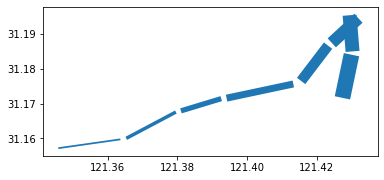

In [27]:
splited_duans.plot()

In [51]:
splited_duans1 = splited_duans.copy()

## 把另一个方向的轨道也算出来

In [46]:
#生成段
step = 10
splited_lines2 = splited_lines2.sort_values(by = 'FLOW')
splited_lines2['linewidth'] = (np.array(range(len(splited_lines2)))*step/len(splited_lines2)).astype('int')/step+0.1
splited_lines2

,FSTR_ONAME,FSTR_DNAME,station_a,station_b,geometry,FLOW,linewidth
0,漕宝路,七宝,漕宝路,上海体育馆,"LINESTRING (121.42962 31.17117, 121.43223 31.1...",200,0.1
1,漕宝路,七宝,上海体育馆,徐家汇,"LINESTRING (121.43233 31.18514, 121.43147 31.1...",250,0.2
2,漕宝路,七宝,徐家汇,宜山路,"LINESTRING (121.43082 31.19577, 121.42317 31.1...",300,0.3
3,漕宝路,七宝,宜山路,桂林路,"LINESTRING (121.42210 31.18754, 121.41437 31.1...",350,0.4
4,漕宝路,七宝,桂林路,漕河泾开发区,"LINESTRING (121.41310 31.17659, 121.39394 31.1...",400,0.6
5,漕宝路,七宝,漕河泾开发区,合川路,"LINESTRING (121.39239 31.17212, 121.38081 31.1...",450,0.7
6,漕宝路,七宝,合川路,星中路,"LINESTRING (121.37934 31.16800, 121.36510 31.1...",500,0.8
7,漕宝路,七宝,星中路,七宝,"LINESTRING (121.36360 31.15995, 121.34576 31.1...",550,0.9


In [47]:
#新建一个变量，splited_duans来存储生成的面
splited_duans2 = splited_lines2.copy()
#设定一下我们想要的面宽度
kuandu = 0.005

In [48]:
#将每一段变成面后赋值给OD的geome属性
geo=[]
for i in range(len(splited_lines2)):
    r = splited_lines.iloc[i]
    ply = Polygon(np.append(np.array(r['geometry'].coords),
    np.array(r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3).coords)).reshape(-1,2))
    geo.append(ply)
splited_duans2['geometry']=geo

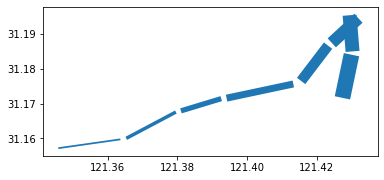

In [49]:
splited_duans2.plot()

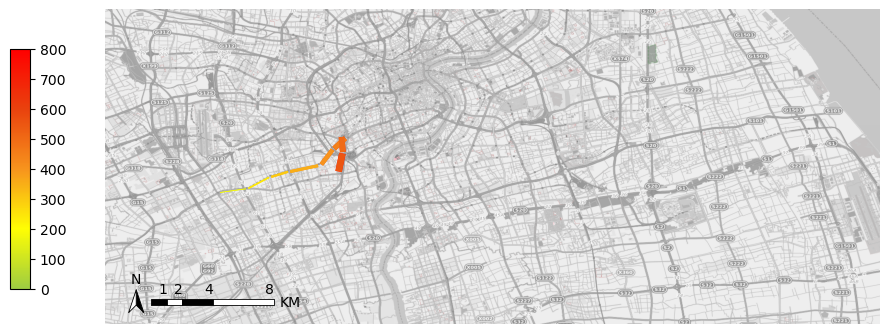

In [52]:
#设定显示范围
lat1sh = 30.8666667;
lat2sh = 31.5833333;
lon1sh = 121.066667;
lon2sh = 122.0;
bounds = [lon1sh+0.2,lat1sh+0.2,lon2sh-0.2,lat2sh-0.3]

import plot_map
#导入必要的包
import pandas as pd
import numpy as np
#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt
#geopandas包
import geopandas

#定义画的大小
fig     = plt.figure(1,(10,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)

#plot_map包绘制背景图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#设定colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)
vmax = splited_duans['FLOW'].max()

#把前面搞出来的画上去
splited_duans1.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)
splited_duans2.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)

# 加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 1000,rect = [0.06,0.06])

#设定显示范围
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#绘制colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.03, 0.35, 0.02, 0.3])
plt.colorbar(cax=cax)

plt.show()